In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading dataset

In [2]:
penguins = pd.read_csv('https://datasets.holoviz.org/penguins/v1/penguins.csv')
penguins = penguins[~penguins.sex.isnull()].reset_index().sort_values('species')

penguins.head(5)

,index,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
94,100,Adelie,Biscoe,35.0,17.9,192.0,3725.0,female,2009
95,101,Adelie,Biscoe,41.0,20.0,203.0,4725.0,male,2009
96,102,Adelie,Biscoe,37.7,16.0,183.0,3075.0,female,2009
97,103,Adelie,Biscoe,37.8,20.0,190.0,4250.0,male,2009


# Standard plots

<Axes: xlabel='body_mass_g', ylabel='sex'>

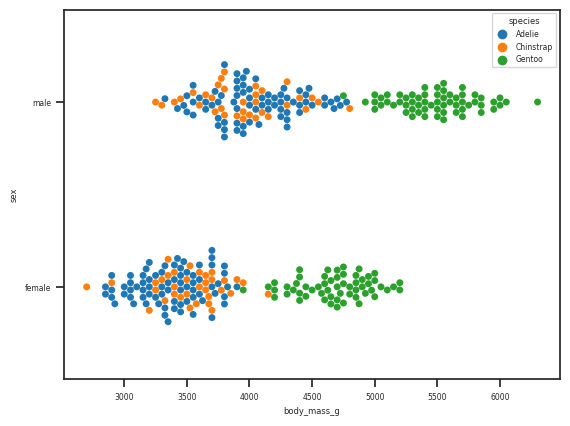

In [3]:
sns.set_style("ticks")
sns.set_context("notebook", font_scale=.5, rc={"lines.linewidth": 2.5})

sns.swarmplot(data=penguins, x="body_mass_g", y="sex", hue="species")

<Axes: xlabel='species', ylabel='flipper_length_mm'>

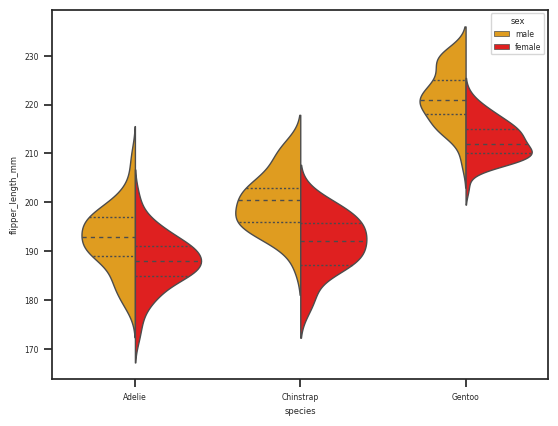

In [4]:
sns.violinplot(data=penguins, y="flipper_length_mm", x='species', hue='sex', split=True, inner="quart", linewidth=1,
               palette={"male": "orange", "female": "red"})

# Aggregation for ridgeline

In [5]:
penguins_df = penguins[['flipper_length_mm', 'species', 'sex']]
penguins_df['species'] = penguins.agg(lambda x: f"{x['species']} {x['sex']}", axis=1)
penguins_df = penguins_df.drop(['sex'], axis='columns')
penguins_df.head(5)

/tmp/ipykernel_20/869956586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_df['species'] = penguins.agg(lambda x: f"{x['species']} {x['sex']}", axis=1)


,flipper_length_mm,species
0,181.0,Adelie male
94,192.0,Adelie female
95,203.0,Adelie male
96,183.0,Adelie female
97,190.0,Adelie male


In [6]:
label_dict = {1: 'Adelie - Male',
              2: 'Adelie - Femal',
              3: 'Chinstrap - Male',
              4: 'Chinstrap - Female',
              5: 'Gentoo - Male',
              6: 'Gentoo - Female'}


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Central Tendency Of Flipper Length')

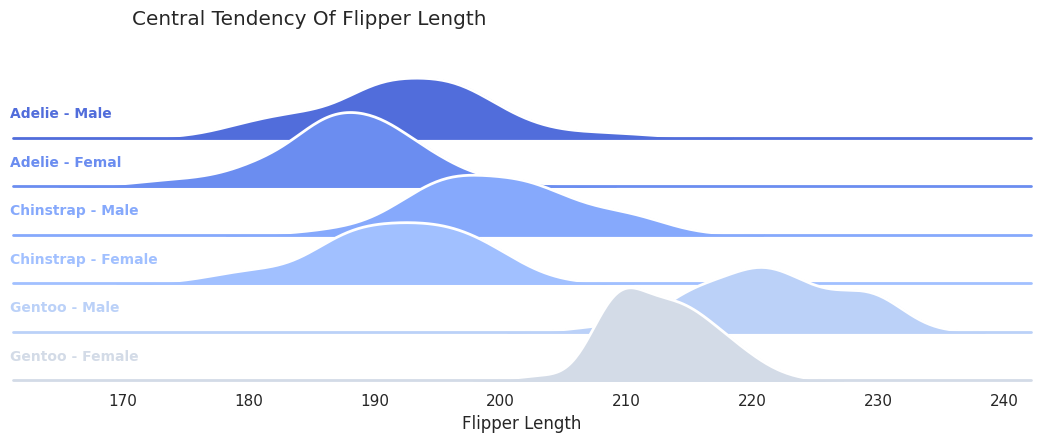

In [7]:
# FacetGrid to create a plot for each category
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})

# Generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=12)

# Making the charts broader and shorter 
# sns.FacetGrid class, the 'hue' argument is the one that will be represented by colors with 'palette'
ridge = sns.FacetGrid(penguins_df, row='species', hue="species", aspect=15, height=.75, palette=pal)

# map_dataframe - to format all the subplots
ridge.map_dataframe(sns.kdeplot, x='flipper_length_mm', bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)

# Add a white line that represents the contour of each kdeplot    
ridge.map_dataframe(sns.kdeplot, 'flipper_length_mm', bw_adjust=1, clip_on=False, color="w", lw=2)

# Add a horizontal line for each plot
ridge.map_dataframe(plt.axhline, y=0, lw=2, clip_on=False)

# Y and X label formatting
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=10,
            ha="left", va="center", transform=ax.transAxes)

# Loop over the FacetGrid figure axes (g.axes.flat) and add the "values" from label_dict as text with the right color
# ax.lines[-1].get_color() enables access the last line's color in each matplotlib.Axes
for i, ax in enumerate(ridge.axes.flat):
    ax.text(161, 0.02, label_dict[i+1],
            fontweight='bold', fontsize=10,
            color=ax.lines[-1].get_color())
    
ridge.set_titles("")
ridge.set(yticks=[], ylabel="", xlabel="Flipper Length")
ridge.despine(bottom=True, left=True)

# subplots_adjust to control the height space between the subplots.
ridge.fig.subplots_adjust(hspace=-.5)
plt.suptitle('Central Tendency Of Flipper Length', ha='right')

# Aggregation for circular barplot

In [8]:
bill_df = penguins.groupby(['species', 'sex'], as_index=False).agg({'bill_length_mm': 'mean', 'bill_depth_mm': 'mean'}, ascending=False).sort_values("bill_length_mm", ascending=False).reset_index(drop=True)
bill_df['species'] = bill_df.agg(lambda x: f"{x['species']} {x['sex']}", axis=1)
final_bill_df = bill_df.drop('sex', axis='columns')
final_bill_df

,species,bill_length_mm,bill_depth_mm
0,Chinstrap male,51.094118,19.252941
1,Gentoo male,49.473770,15.718033
2,Chinstrap female,46.573529,17.588235
3,Gentoo female,45.563793,14.237931
4,Adelie male,40.390411,19.072603
5,Adelie female,37.257534,17.621918


In [9]:
# Values for the x axis - space between bars
ANGLES = np.linspace(0.40, 2 * np.pi - 0.10, 6, endpoint=False)

# Average length and depth
LENGTHS = final_bill_df["bill_length_mm"]
DEPTHS = final_bill_df["bill_depth_mm"]

# Species and Sex label
CATEGORIES = final_bill_df['species']

In [10]:
# Colors
COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195"]

# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

# Normalizer
norm = mpl.colors.Normalize(vmin=LENGTHS.min(), vmax=LENGTHS.max())

# Normalized colors. Each number of tracks is mapped to a color in the 
# color scale 'cmap'
COLORS = cmap(norm(LENGTHS))

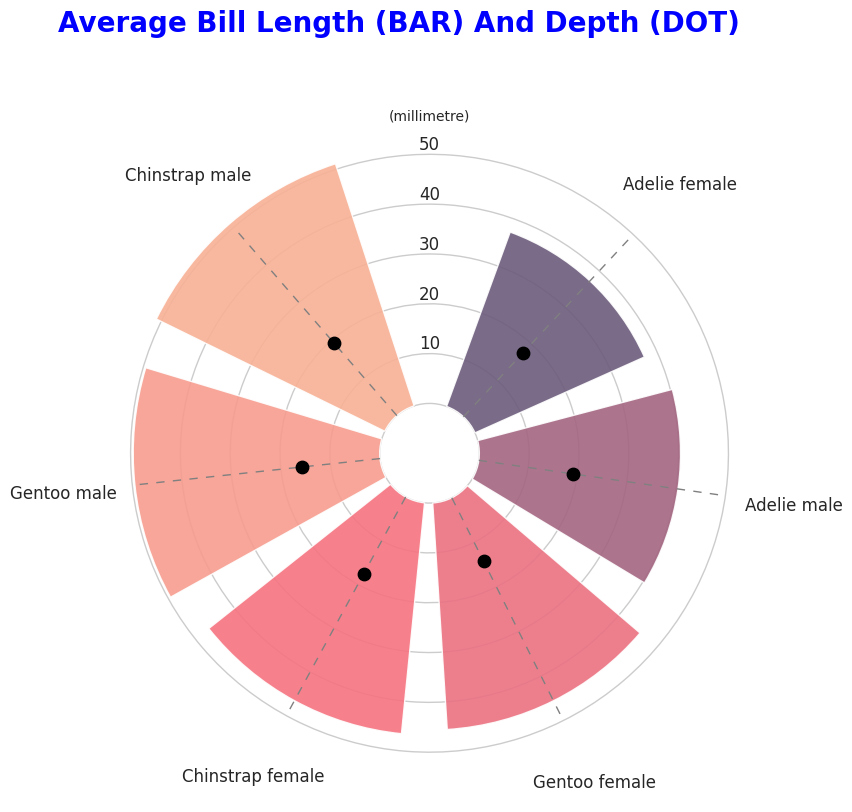

In [11]:
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(-10, 60)

# Add geometries to the plot - zorder to manipulate which geometries are on top
# Add bars to represent average bill length
bars = ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.8, zorder=10)
# ax.bar_label(bars,label_type="edge",fontsize=16)

# Add dotted lines. These are just references
ax.vlines(ANGLES, 0, 50, color="grey", ls=(0, (6, 6)), linewidth=1, zorder=11)

# Add dots to represent the bill depth
ax.scatter(ANGLES, DEPTHS, s=80, color='black', zorder=11)

# Remove lines for polar axis (x)
ax.xaxis.grid(False)
# Lines for axis y
ax.yaxis.grid(True)

# Add labels for bars
CATEGORIES = [r for r in CATEGORIES]
CATEGORIES

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(CATEGORIES, size=12)

# Put grid lines for radial axis (y) at 0, 10, 20, 30, 40, 50
ax.set_yticklabels([])
ax.set_yticks([0, 10, 20, 30, 40, 50])

# Remove spines
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")

# Adjust padding of the x axis labels
XTICKS = ax.xaxis.get_major_ticks()
for tick in XTICKS:
    tick.set_pad(1)

# Add custom annotations
# The following represent the heights in the values of the y axis
PAD = 1
ax.text(-0.2 * np.pi / 2, 10 + PAD, "10", ha="center", size=12)
ax.text(-0.2 * np.pi / 2, 20 + PAD, "20", ha="center", size=12)
ax.text(-0.2 * np.pi / 2, 30 + PAD, "30", ha="center", size=12)
ax.text(-0.2 * np.pi / 2, 40 + PAD, "40", ha="center", size=12)
ax.text(-0.2 * np.pi / 2, 50 + PAD, "50", ha="center", size=12)
ax.text(-0.2 * np.pi / 2, 56 + PAD, "(millimetre)", ha="center", size=10)
title = "Average Bill Length (BAR) And Depth (DOT)"
fig.text(0.1, 0.83, title, fontsize=20,color="blue", weight="bold", ha="left", va="baseline");